# Introduction and Motivation

In the era of digital media, music streaming platforms have transformed how we discover and enjoy music. Services like Spotify have millions of tracks available at our fingertips, making music recommendation systems essential for enhancing user experience. Recognizing the significance of these systems, our team chose to explore the “Spotify Tracks, Genre, Audio Features” dataset from Kaggle (https://www.kaggle.com/datasets/pepepython/spotify-huge-database-daily-charts-over-3-years/data) using PySpark to analyze trends and build a music recommendation model.

Our motivation for selecting this dataset is rooted in a desire to engage with a more intriguing and relatable subject matter than the typical technical datasets we’ve encountered in previous classes. Music is a universal language, and understanding how recommendation systems work within this context is both exciting and relevant. Music recommendation models are increasingly important as the amount of data generated online continues to grow, impacting how users interact with streaming services.

The primary objectives of our project are twofold:
1. Data Analysis: We aim to understand trends within the music data by examining how different genres relate to specific audio feature metrics. For example, we want to investigate whether certain genres consistently exhibit higher danceability scores or how energy levels vary across genres.
2. Model Building: Utilizing machine learning techniques, we plan to develop a music recommendation model. This model will leverage the insights gained from our data analysis to suggest tracks that align with user preferences based on audio features.

Our project focuses on mainstream music, as the dataset predominantly features popular tracks. While we have considered algorithms like K-Nearest Neighbors for recommendation, we will determine the most suitable machine learning methods as we progress, ensuring they align with our dataset characteristics and project goals.

# Data Collection

In [2]:
from pyspark.sql import SparkSession


if SparkSession._instantiatedSession is not None:
    print("An existing SparkSession is detected.")
    SparkSession._instantiatedSession.stop()


# Initialize a Spark session
# Start a new Spark session
spark = SparkSession.builder \
    .appName("MusicDataAnalysisProject") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate() 
    

spark.sparkContext.setLogLevel("ERROR")

# Path to your CSV file
csv_path = "../Music_Database.csv"

music_df = spark.read.option("header", "true").csv(csv_path, inferSchema=True)
music_df = music_df.withColumnRenamed("Country", "Country0")

# Show the first few rows to verify
music_df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 12:20:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----------+--------------------+------------------+---------------+--------------------+------------+-----------------+----------------+--------+--------------------+------------+------------+---------------+------------------+------------------+---+--------+----+-----------+-------------------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-------------------+------------+-------------------+-------------------+------------------+-------------+-------------------+------------------+-------------------+-----------+------------------+-------------+--------

# Data Inspection and Validation

Numerical columns are String in the schema, so we'll convert them to numeric types later on (Data Transformation).

In [3]:
# Print the schema of the DataFrame
music_df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acoustics: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveliness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: 

Check for null and duplicates in the dataset. Also, check the distribution of popularity scores because later we will categoprize the data by low, medium, and high popularity levels.

In [4]:
from pyspark.sql.functions import col, sum, count, when
# Count null values in each column
null_counts = music_df.select([count(when(col(c).isNull(), c)).alias(c) for c in music_df.columns])
null_counts.show()

# Check for duplicates
duplicate_count = music_df.count() - music_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Check popularity range for validity (e.g., ensure no extreme outliers)
music_df.select("Popularity").describe().show()


+--------+---+----------+-----+------+------------+-----+----------------+--------+------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-----+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+-----+-----+-----+-----+------------+-------+-----+-----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+---------------+-----+--------------+-------------+--

Number of duplicate rows: 0
+-------+------------------+
|summary|        Popularity|
+-------+------------------+
|  count|            170633|
|   mean| 5417.616264145855|
| stddev|13115.854525897726|
|    min|               0.8|
|    max|233766.89999999988|
+-------+------------------+



# Data Filtering

In [5]:
# Further refine by North America
filtered_df = music_df.filter((music_df.Country0 == "USA") | (music_df.Country0 == "Canada") | (music_df.Country0 == "Mexico"))

print(f"Number of rows: {filtered_df.count()}")


Number of rows: 15113


# Data Transformation

In [6]:
from pyspark.sql.functions import col

# List of columns to cast to integer or double as appropriate
int_columns = ["Track_number", "Tracks_in_album", "time_signature", "Argentina", "Australia", "Austria", 
               "Belgium", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Denmark", "Ecuador", 
               "Finland", "France", "Germany", "Global", "Indonesia", "Ireland", "Italy", "Malaysia", 
               "Mexico", "Netherlands", "New Zealand", "Norway", "Peru", "Philippines", "Poland", 
               "Portugal", "Singapore", "Spain", "Sweden", "Switzerland", "Taiwan", "Turkey", "UK", "USA"]

double_columns = ["Popularity", "Artist_followers", "danceability", "energy", "key", "loudness", 
                  "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence", 
                  "tempo", "duration_ms", "Days_since_release", "syuzhet_norm", "bing_norm", "afinn_norm", 
                  "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation", "disgust", "fear", 
                  "joy", "sadness", "surprise", "trust", "negative", "positive", "n_words", "anger_norm", 
                  "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm", "sadness_norm", "surprise_norm", 
                  "trust_norm", "negative_norm", "positive_norm", "anger_norm2", "anticipation_norm2", 
                  "disgust_norm2", "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2", 
                  "negative_norm2", "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes", 
                  "Negative_Bayes", "Neutral_Bayes", "Positive_Bayes", "Desire", "Explore", "Fun", 
                  "Hope", "Love", "Nostalgia", "Thug", "bing_norm_negative"]

# Cast columns to integer
for column in int_columns:
    filtered_df = filtered_df.withColumn(column, col(column).cast("int"))

# Cast columns to double
for column in double_columns:
    filtered_df = filtered_df.withColumn(column, col(column).cast("double"))

# Assign to transformed_df to avoid confusion
transformed_df = filtered_df

# Verify the updated schema
transformed_df.printSchema()


root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: double (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: string (nullable = true)
 |-- Track_number: integer (nullable = true)
 |-- Tracks_in_album: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acoustics: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveliness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms

In [7]:
# Define popularity categories
transformed_df = transformed_df.withColumn(
    "PopularityCategory",
    when(transformed_df.Popularity < 5000, "Low")
    .when((transformed_df.Popularity >= 5000) & (transformed_df.Popularity < 18000), "Medium")
    .otherwise("High")
)

# Exploratory Data Analysis

In [118]:
# Define relevant numerical features to explore
numerical_features = [
   "Popularity", "Artist_followers", "danceability", "energy", "key", "loudness", 
    "mode", "speechiness", "acoustics", "instrumentalness", "liveliness", "valence", 
    "tempo", "duration_ms", "time_signature", "Days_since_release", "Released_after_2017", 
    "Explicit_false", "Explicit_true", "syuzhet_norm", "bing_norm", "afinn_norm", 
    "nrc_norm", "syuzhet", "bing", "afinn", "nrc", "anger", "anticipation", 
    "disgust", "fear", "joy", "sadness", "surprise", "trust", "negative", "positive", 
    "n_words", "anger_norm", "anticipation_norm", "disgust_norm", "fear_norm", 
    "joy_norm", "sadness_norm", "surprise_norm", "trust_norm", "negative_norm", 
    "positive_norm", "anger_norm2", "anticipation_norm2", "disgust_norm2", "fear_norm2", 
    "joy_norm2", "sadness_norm2", "surprise_norm2", "trust_norm2", "negative_norm2", 
    "positive_norm2", "negative_bog_jr", "positive_bog_jr", "Bayes", "Negative_Bayes", 
    "Neutral_Bayes", "Positive_Bayes", "Popu_max", "Top10_dummy", "Top50_dummy"
]

# Filter the DataFrame for these columns
numerical_df = transformed_df.select([col for col in numerical_features if col in transformed_df.columns])

# Perform .describe() 
numerical_df.describe().show()

+-------+------------------+--------------------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------

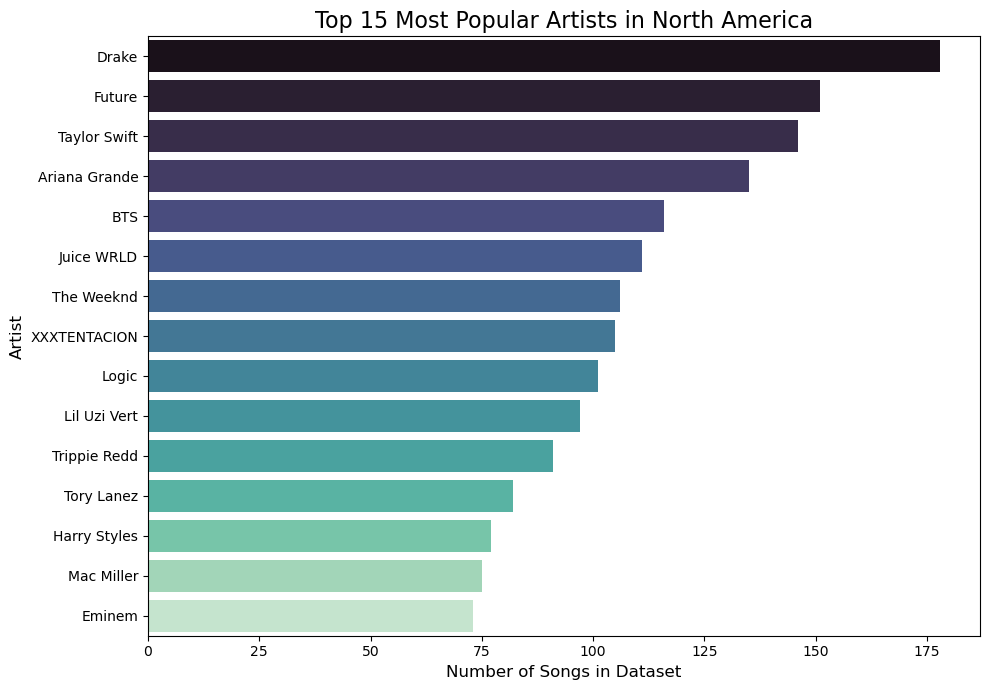

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each artist
artist_counts = (
    transformed_df.groupBy("Artist")
    .count()
    .orderBy(col("count").desc())  # Sort in descending order
    .limit(15)  # Select the top 15 artists
    .toPandas()  # Convert to Pandas for visualization
)

# Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=artist_counts, x="count", y="Artist", hue="Artist", legend = False, palette='mako')

# Customize the plot
plt.title("Top 15 Most Popular Artists in North America", fontsize=16)
plt.xlabel("Number of Songs in Dataset", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


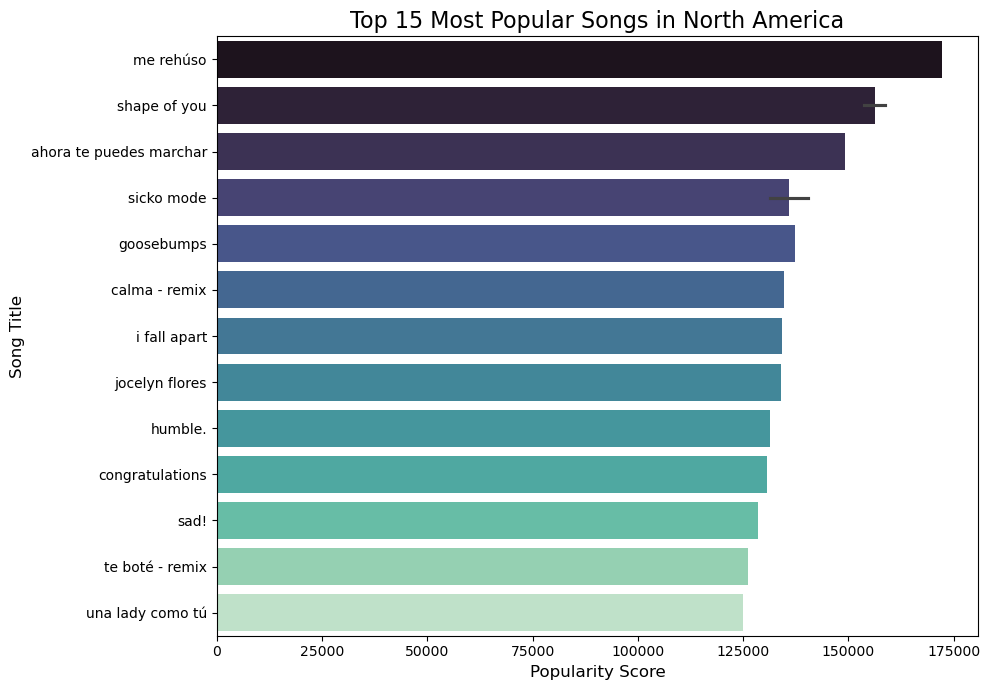

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Step 1: Select the top 15 most popular songs by Popularity
popular_songs = (
    transformed_df.select("Title", "Popularity")
    .orderBy(col("Popularity").desc())  # Sort by popularity in descending order
    .limit(15)  # Select the top 15 songs
    .toPandas()  # Convert to Pandas for visualization
)

# Step 2: Plot the data
plt.figure(figsize=(10, 7))
sns.barplot(data=popular_songs, x="Popularity", y="Title", hue="Title", legend = False, palette='mako')

# Step 3: Customize the plot
plt.title("Top 15 Most Popular Songs in North America", fontsize=16)
plt.xlabel("Popularity Score", fontsize=12)
plt.ylabel("Song Title", fontsize=12)
plt.tight_layout()

# Step 4: Show the plot
plt.show()


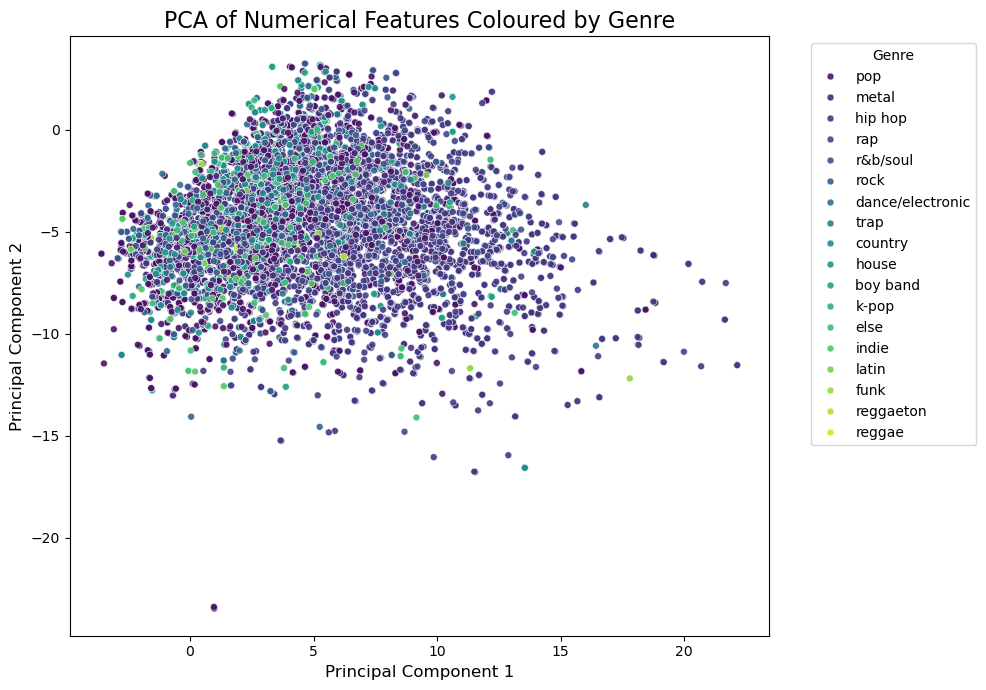

In [241]:
# Perform PCA analysis to visualize the high-dimensional data
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

# Remove rows with nulls in numerical features (as required by VectorAssembler)
pca_ready_df = transformed_df.dropna(subset=numerical_features)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_assembled")
df_with_features = assembler.transform(pca_ready_df)

# Scale the features
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled")
scaler_model = scaler.fit(df_with_features)
df_scaled = scaler_model.transform(df_with_features)

# Apply PCA to the scaled features
pca = PCA(k=2, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
pca_result = pca_model.transform(df_scaled)

# Convert PCA result to Pandas for visualization
pandas_df = pca_result.select("pca_features", "Genre_new", 'positive', 'Explicit_true').toPandas()
pandas_df[['PCA1', 'PCA2']] = pandas_df['pca_features'].apply(lambda x: list(x)).to_list()

# Create a scatter plot for PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1",
    y="PCA2",  
    hue="Genre_new",  # Color by Genre_new
    data=pandas_df,
    palette="viridis",
    s=25,  # Point size
    alpha=0.9  # Transparency
)

# Add labels and title
plt.title("PCA of Numerical Features Coloured by Genre", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Add legend and layout adjustments
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

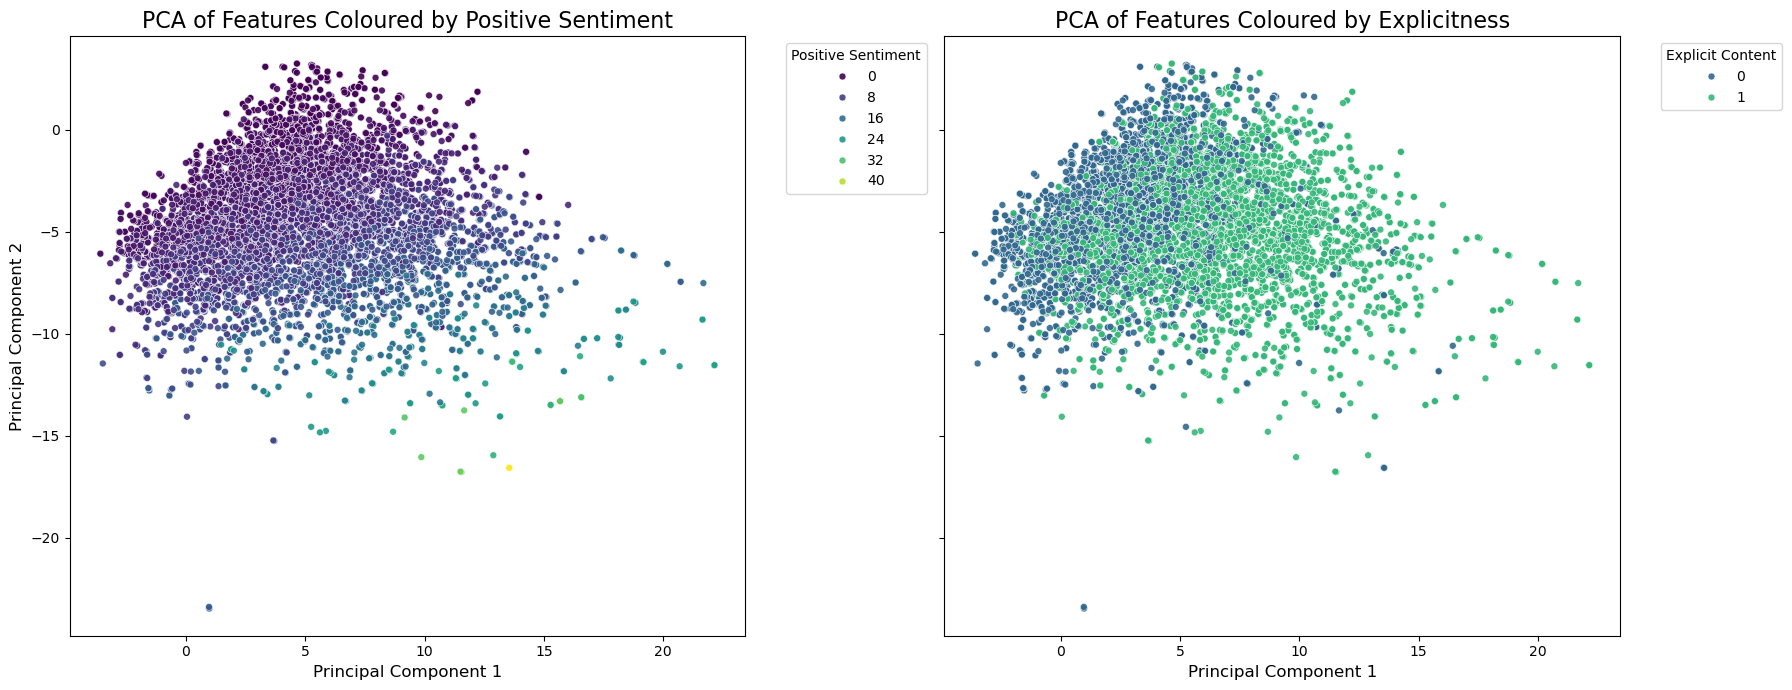

In [247]:
# Create 2 more subplots for PCA results with different hues
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# PCA with hue = 'positive'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="positive",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[0]
)
axes[0].set_title("PCA of Features Coloured by Positive Sentiment", fontsize=16)
axes[0].set_xlabel("Principal Component 1", fontsize=12)
axes[0].set_ylabel("Principal Component 2", fontsize=12)
axes[0].legend(title="Positive Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: PCA with hue = 'Explicit_true'
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Explicit_true",
    data=pandas_df, palette="viridis", s=25, alpha=0.9, ax=axes[1]
)
axes[1].set_title("PCA of Features Coloured by Explicitness", fontsize=16)
axes[1].set_xlabel("Principal Component 1", fontsize=12)
axes[1].legend(title="Explicit Content", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

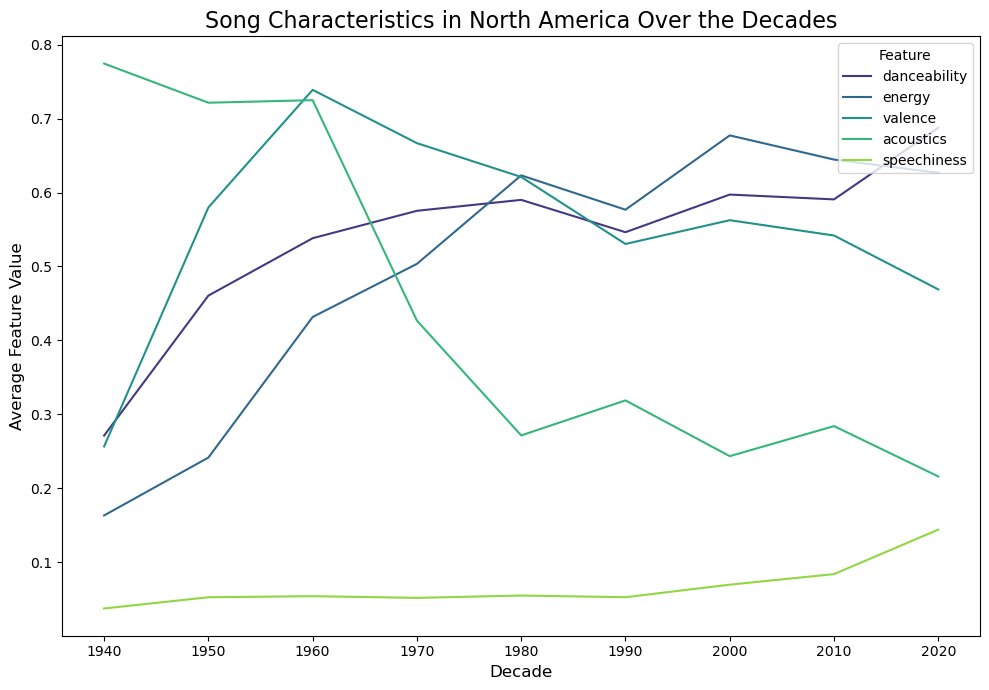

In [234]:
from pyspark.sql import functions as func

# Define features to plot and extract decades
music_features = ['danceability', 'energy', 'valence', 'acoustics', 'speechiness']

# Group by Decade and calculate the mean for each feature
aggregated_df = (transformed_df
                 .withColumn("Decade", func.round(func.year(func.to_date("Release_Date", "yyyy-MM-dd")), -1))
                 .groupBy("Decade")
                 .agg(
                     *[func.avg(feature).alias(feature) for feature in music_features]
                 )
                 .orderBy("Decade")
                 .toPandas()
                 .dropna()  # Drop rows with missing values
                )

# Melt data for seaborn plotting
melted_df = aggregated_df.melt(id_vars="Decade", 
                                value_vars=music_features, 
                                var_name="Feature", 
                                value_name="Value")

# Plot using Seaborn
plt.figure(figsize=(10, 7))
sns.lineplot(data=melted_df, x="Decade", y="Value", hue="Feature", palette='viridis')

# Customize plot
plt.title("Song Characteristics in North America Over the Decades", fontsize=16)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Average Feature Value", fontsize=12)
plt.legend(title="Feature", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()


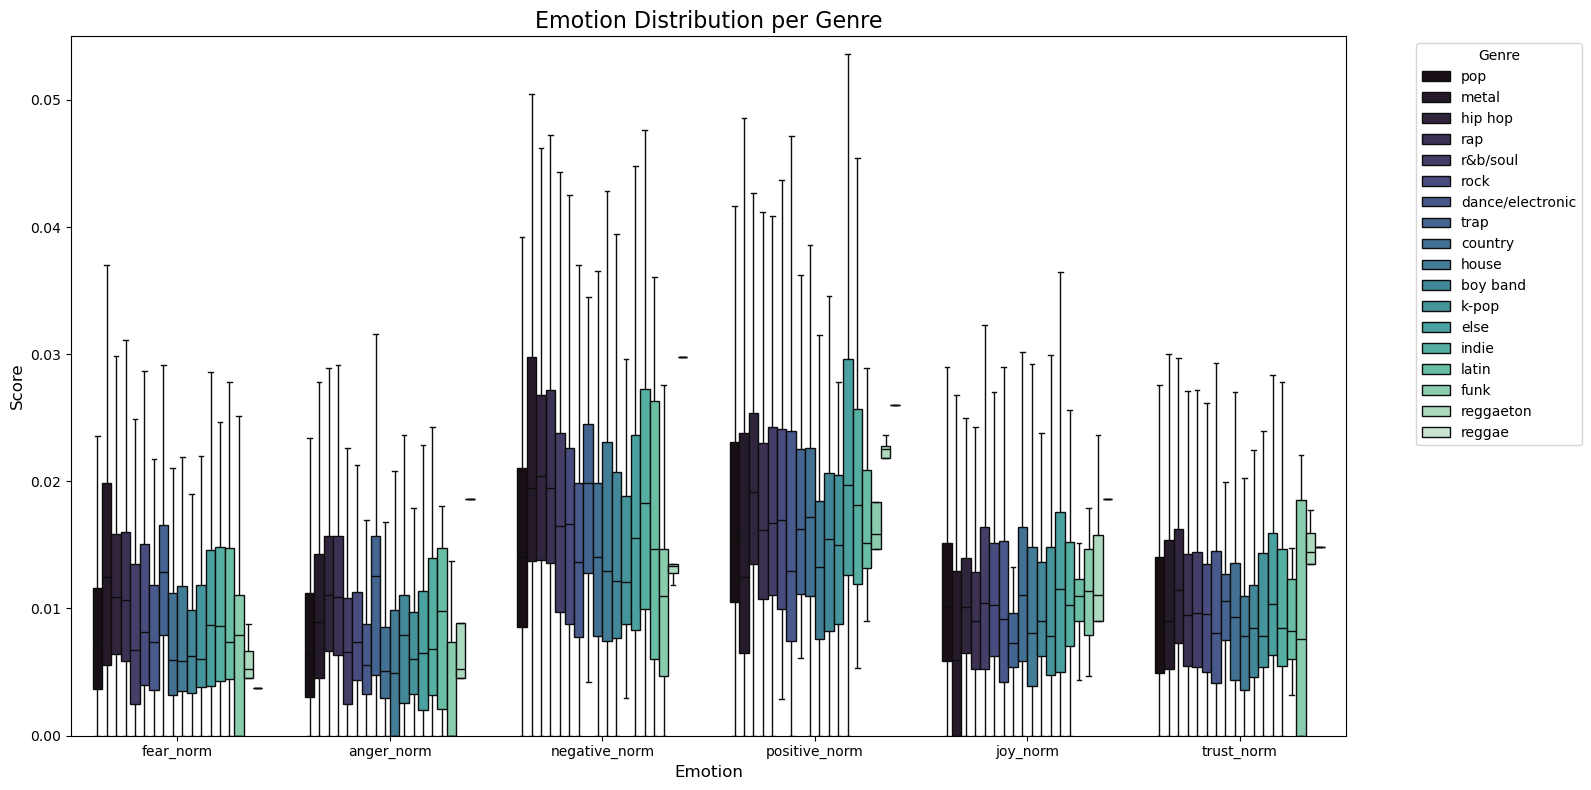

In [245]:
# Plot emotion distribtuion per Genre
sentiment_scores = ["fear_norm", "anger_norm", "negative_norm", "positive_norm", "joy_norm", "trust_norm"]

# Select relevant columns (sentiment scores + Genre)
emotion_df = transformed_df.dropna(subset=numerical_features).select(sentiment_scores + ["Genre_new"]).toPandas()

# Melt the data for easier plotting
melted_df = emotion_df.melt(
    id_vars="Genre_new", 
    value_vars=sentiment_scores, 
    var_name="Emotion", 
    value_name="Score"
)

# Plot the data
plt.figure(figsize=(16, 8))
sns.boxplot(data=melted_df, x="Emotion", y="Score", hue="Genre_new", palette = 'mako', showfliers=False)

# Customize the plot
plt.title("Emotion Distribution per Genre", fontsize=16)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 0.055)  # Adjust y-axis to match the range of norms
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()

# Show the plot
plt.show()
